# Sample Usage

This notebook demonstrates basic usage of the unified NASBench API wrappers and plots distributions of accuracies for each benchmark (where available).


## Imports

In [1]:
import random
import itertools
from pprint import pprint
from collections import defaultdict, Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nasbenchapi import NASBench101, NASBench201, NASBench301, Arch101

# Recommended: set paths via env vars (NASBENCH101_PATH, NASBENCH201_PATH, NASBENCH301_PATH)
# Alternatively: pass the absolute paths to the constructor as the first argument
nb101 = NASBench101()      # Optional: set `verbose=False` to silence loading logs
nb201 = NASBench201()
nb301 = NASBench301()

benchmarks = {
    'nb101': nb101,
    'nb201': nb201,
    'nb301': nb301,
}


Loading NB101 from /Users/{username}/Documents/NASBench/101/nasbench101_full.pkl (1.7 GB)


Reading: 100%|██████████████████████████████████████████████████| 1.84G/1.84G [00:00<00:00, 4.19GB/s]


Unpickling data...
Unpickling complete.
[NB101] Loaded 359082 architectures (records=4308984)
Loading NB201 from /Users/{username}/Documents/NASBench/201/nasbench201_v1_0-e61699.pkl (1.8 GB)


Reading: 100%|██████████████████████████████████████████████████| 1.90G/1.90G [00:00<00:00, 7.76GB/s]


Unpickling data...
Unpickling complete.
[NB201] Loaded 15625 architectures (source=arch2infos)
Loading NB301 from /Users/{username}/Documents/NASBench/301/nasbench301.pkl (1.1 GB)


Reading: 100%|██████████████████████████████████████████████████| 1.17G/1.17G [00:00<00:00, 4.07GB/s]


Unpickling data...
Unpickling complete.
[NB301] Loaded 57189 entries (source=directory)


## Sampling and Querying

In [2]:
# Sampling architectures randomly and evaluating them

random.seed(0)
N_SAMPLES = 200

nb101_sample_vals = []
print(f'Sampling {N_SAMPLES} architectures from NB101')
nb101_samples = nb101.random_sample(n=N_SAMPLES, seed=0)
print('Querying sampled architectures...')
for a in nb101_samples:
    r = nb101.query(a, dataset='cifar10', split='val')
    if r['metric'] is not None:
        nb101_sample_vals.append(r['metric'])

nb201_sample_vals = []
print(f'Sampling {N_SAMPLES} architectures from NB201')
nb201_samples = nb201.random_sample(n=N_SAMPLES, seed=0)
print('Querying sampled architectures...')
for s in nb201_samples:
    r = nb201.query(s, dataset='cifar10', split='val', budget=199)
    if r['metric'] is not None:
        nb201_sample_vals.append(r['metric'])

nb301_sample_vals = []
print(f'Sampling {N_SAMPLES} architectures from NB301')
nb301_samples = nb301.random_sample(n=N_SAMPLES, seed=0)
print('Querying sampled architectures...')
for x in nb301_samples:
    r = nb301.query(x, dataset='cifar10', split='val')
    if r['metric'] is not None:
        nb301_sample_vals.append(r['metric'])

print(f"NB101 queried sample values found: {len(nb101_sample_vals)}")
print(f"NB201 queried sample values found: {len(nb201_sample_vals)}")
print(f"NB301 queried sample values found: {len(nb301_sample_vals)}")


Sampling 200 architectures from NB101
Querying sampled architectures...
Sampling 200 architectures from NB201
Querying sampled architectures...
Sampling 200 architectures from NB301
Querying sampled architectures...
NB101 queried sample values found: 200
NB201 queried sample values found: 113
NB301 queried sample values found: 200


In [3]:
# Query by individual arch strings


''' 
    NB101 Manual Querying
'''
nb101_arch = Arch101(
    adjacency=[
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0],
    ],
    operations=[
        'input',
        'conv3x3-bn-relu',
        'conv1x1-bn-relu',
        'maxpool3x3',
        'conv3x3-bn-relu',
        'conv1x1-bn-relu',
        'output',
    ],
)
nb101_manual = nb101.query(nb101_arch, dataset='cifar10', split='val')



''' 
    NB201 Manual Querying
'''
# NB201: query using a canonical architecture string (all skip connections)
nb201_arch = '|skip_connect~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|skip_connect~1|skip_connect~2|'
nb201_manual = nb201.query(nb201_arch, dataset='cifar10', split='val', budget=199)


''' 
    NB301 Manual Querying
'''
# NB301: select a concrete entry by index and probe multiple budgets
nb301_index = 0
nb301_val_final = nb301.query(nb301_index, dataset='cifar10', split='val')
nb301_val_mid = nb301.query(nb301_index, dataset='cifar10', split='val', budget=50)
nb301_test_final = nb301.query(nb301_index, dataset='cifar10', split='test')


''' 
    Results
'''
print('NB101 hard-coded architecture (val):')
pprint({'metric': nb101_manual['metric'], 'info': nb101_manual['info']})

print('NB201 arch string (val@199):')
pprint({'metric': nb201_manual['metric'], 'info': nb201_manual['info']})

print('NB301 entry idx=0 summary:')
pprint({
    'val_final': nb301_val_final['metric'],
    'val_epoch50': nb301_val_mid['metric'],
    'test_final': nb301_test_final['metric'],
    'epoch_used_final': nb301_val_final['info'].get('epoch_used'),
    'epochs_available': nb301_val_final['info'].get('epochs_available'),
})


NB101 hard-coded architecture (val):
{'info': {'adjacency_str': '0100000001000000010000000100000001000000010000000',
          'derived': {'test_accuracy': 0.22790054293708034,
                      'train_accuracy': 0.5591159588164291,
                      'trainable_parameters': 2662085,
                      'training_time': 37882.02937477451,
                      'validation_accuracy': 0.7939343302638545},
          'epoch': 108,
          'metrics_b64': 'Ci0JAAAAAAAAAAARAAAAAAAAAAAZAAAAYJAGuj8hAAAA4CANuj8pAAAAAGmQuT8KLQkAAAAAAABL\n'
                         'QBEAAAAAKlqWQBkAAAAg3/K6PyEAAABg+Za6PykAAADA5Vu6PwotCQAAAAAAAFtAEQAAAGCkUaZA\n'
                         'GQAAAGAn1u8/IQAAACAN0us/KQAAAACXj+s/EIqXowoZAAAo83A5qEA=\n',
          'operations_str': 'input,conv3x3-bn-relu,conv1x1-bn-relu,maxpool3x3,conv3x3-bn-relu,conv1x1-bn-relu,output'},
 'metric': 0.7939343302638545}
NB201 arch string (val@199):
{'info': {'arch_index': 1835,
          'arch_str': '|skip_connect~0|+|skip_conne

## Introspection

### Loading summary

In [4]:

print("Benchmark statistics and supported datasets:")
for name, bench in benchmarks.items():
    datasets = bench.datasets()
    first_dataset = datasets[0] if datasets else None
    print(f"- {name.upper()}: datasets={datasets}")
    if first_dataset:
        print(f"  splits@{first_dataset}: {bench.splits(first_dataset)}")
    if hasattr(bench, "api") and hasattr(bench.api, "get_statistics"):
        stats = bench.api.get_statistics()
        if stats:
            pprint({k: stats[k] for k in sorted(stats)})
    print()


Benchmark statistics and supported datasets:
- NB101: datasets=['cifar10']
  splits@cifar10: ['train', 'val', 'test']
{'architectures': 359082, 'benchmark': 'nasbench101', 'records': 4308984}

- NB201: datasets=['cifar10', 'cifar100', 'ImageNet16-120']
  splits@cifar10: ['train', 'val', 'test']
{'benchmark': 'nasbench201', 'entries': 15625}

- NB301: datasets=['cifar10', 'cifar100']
  splits@cifar10: ['val', 'test']
{'benchmark': 'nasbench301', 'files': 57189}



### Budget coverage

In [5]:

def _canonical_name(label: str) -> str:
    lowered = label.lower()
    if lowered.startswith('cifar10'):
        return 'cifar10'
    if lowered.startswith('cifar100'):
        return 'cifar100'
    if lowered.startswith('imagenet16-120'):
        return 'ImageNet16-120'
    return label

def _parse_budget_suffix(metric_key: str, prefix: str):
    if not isinstance(metric_key, str) or not metric_key.startswith(prefix):
        return None
    try:
        return int(metric_key[len(prefix):])
    except ValueError:
        return None

def summarize_nb101(bench):
    entries = bench.api.data.get('entries_by_arch')
    if not isinstance(entries, dict) or not entries:
        entries = bench.api.data.get('latest_by_arch', {})
    total = len(entries) if isinstance(entries, dict) else 0
    rows = []
    for dataset in bench.datasets():
        for split in bench.splits(dataset):
            rows.append({
                'benchmark': 'nb101',
                'dataset': dataset,
                'split': split,
                'budget': 'n/a',
                'architectures': total,
            })
    return rows

def summarize_nb201(bench):
    counts = defaultdict(int)
    data = getattr(bench.api, 'data', {})
    arch2infos = data.get('arch2infos', {})
    for arch_info in arch2infos.values():
        if not isinstance(arch_info, dict):
            continue
        full = arch_info.get('full', {})
        all_results = full.get('all_results', {})
        per_split = defaultdict(set)
        for (dataset_key, _seed), result in all_results.items():
            if not isinstance(result, dict):
                continue
            dataset_name = _canonical_name(dataset_key.replace('-valid', ''))
            if not dataset_name:
                continue
            eval_acc = result.get('eval_acc1es', {})
            if isinstance(eval_acc, dict):
                for metric_key in eval_acc.keys():
                    budget = _parse_budget_suffix(metric_key, 'x-valid@')
                    if budget is not None:
                        per_split[(dataset_name, 'val')].add(int(budget))
                    budget = _parse_budget_suffix(metric_key, 'ori-test@')
                    if budget is not None:
                        per_split[(dataset_name, 'test')].add(int(budget))
            train_acc = result.get('train_acc1es')
            if isinstance(train_acc, dict):
                train_budgets = []
                for key in train_acc.keys():
                    try:
                        train_budgets.append(int(key))
                    except (TypeError, ValueError):
                        continue
                if train_budgets:
                    per_split[(dataset_name, 'train')].update(train_budgets)
            elif isinstance(train_acc, list):
                per_split[(dataset_name, 'train')].update(range(len(train_acc)))
        for (dataset_name, split), budgets in per_split.items():
            for budget in budgets:
                counts[(dataset_name, split, budget)] += 1
    rows = []
    for (dataset_name, split, budget), count in counts.items():
        rows.append({
            'benchmark': 'nb201',
            'dataset': dataset_name,
            'split': split,
            'budget': int(budget),
            'architectures': count,
        })
    return rows

def summarize_nb301(bench):
    counts = defaultdict(int)
    data = getattr(bench.api, 'data', {})
    entries = data.get('entries', [])
    for entry in entries:
        if not isinstance(entry, dict):
            continue
        parsed = entry.get('parsed', {})
        dataset_name = bench.api._infer_dataset(parsed)
        if not dataset_name:
            continue
        val_curve = bench.api._get_learning_curve(parsed, 'Train/val_accuracy')
        if val_curve:
            epochs = len(val_curve)
            for epoch in range(1, epochs + 1):
                counts[(dataset_name, 'val', epoch)] += 1
        budget = parsed.get('budget')
        try:
            if budget is not None:
                counts[(dataset_name, 'test', int(budget))] += 1
        except (TypeError, ValueError):
            continue
    rows = []
    for (dataset_name, split, budget), count in counts.items():
        rows.append({
            'benchmark': 'nb301',
            'dataset': dataset_name,
            'split': split,
            'budget': int(budget),
            'architectures': count,
        })
    return rows

budget_rows = []
budget_rows.extend(summarize_nb101(nb101))
budget_rows.extend(summarize_nb201(nb201))
budget_rows.extend(summarize_nb301(nb301))

budget_df = pd.DataFrame(budget_rows)
budget_df['budget'] = budget_df['budget'].astype(str)
budget_df['budget_numeric'] = pd.to_numeric(budget_df['budget'], errors='coerce')
BudgetSummary = (
    budget_df
    .sort_values(['benchmark', 'dataset', 'split', 'budget_numeric', 'budget'])
    .drop(columns=['budget_numeric'])
    .reset_index(drop=True)
)
BudgetSummary


,benchmark,dataset,split,budget,architectures
0,nb101,cifar10,test,n/a,359082
1,nb101,cifar10,train,n/a,359082
2,nb101,cifar10,val,n/a,359082
3,nb201,ImageNet16-120,test,0,15625
4,nb201,ImageNet16-120,test,1,15625
...,...,...,...,...,...
1098,nb301,cifar10,val,94,56620
1099,nb301,cifar10,val,95,56618
1100,nb301,cifar10,val,96,56613
1101,nb301,cifar10,val,97,56602


### Dataset previews

In [6]:
# Preview a few samples for each benchmark
s101 = nb101.random_sample(n=2, seed=1)
s201 = nb201.random_sample(n=2, seed=1)
s301_indices = nb301.random_sample(n=2, seed=1)

print('NB101 sample type:', type(s101[0]).__name__)
print('NB201 sample type:', type(s201[0]).__name__)
print('NB301 sample type:', type(s301_indices[0]).__name__)

example_nb101 = nb101.query(s101[0], dataset='cifar10', split='val')
example_nb201 = nb201.query(s201[0], dataset='cifar10', split='val', budget=199)
example_nb301_final = nb301.query(s301_indices[0], dataset='cifar10', split='val')
val_budgets = nb301.available_budgets('cifar10', 'val') or []
nb301_budget = val_budgets[len(val_budgets) // 4] if val_budgets else None
example_nb301_mid = (
    nb301.query(s301_indices[0], dataset='cifar10', split='val', budget=nb301_budget)
    if nb301_budget is not None else None
)
example_nb301_test = nb301.query(s301_indices[0], dataset='cifar10', split='test')

print('NB101 example val metric:', example_nb101['metric'])
print('NB201 example val metric @199:', example_nb201['metric'])
print('NB301 example val metric (final):', example_nb301_final['metric'])
if example_nb301_mid:
    print(f"NB301 example val metric @{nb301_budget}:", example_nb301_mid['metric'])
print('NB301 example test metric:', example_nb301_test['metric'])


NB101 sample type: Arch101
NB201 sample type: str
NB301 sample type: int
NB101 example val metric: 0.5154885542638639
NB201 example val metric @199: 68.94
NB301 example val metric (final): 93.44000244140625
NB301 example val metric @25: 81.80000305175781
NB301 example test metric: 93.25


### Accuracies' distributions per benchmark

In [7]:
# Collect full benchmark distributions (validation accuracies for CIFAR-10)

print('Collecting NB101 validation accuracies...')
nb101_full_vals = []
latest_by_arch = nb101.api.data.get('latest_by_arch', {})
for item in latest_by_arch.values():
    if not isinstance(item, dict):
        continue
    derived = item.get('derived', {})
    val = derived.get('validation_accuracy')
    if val is not None:
        nb101_full_vals.append(float(val))
print(f'NB101 architectures with val accuracy: {len(nb101_full_vals)}')

print('Collecting NB201 validation accuracies (final budgets)...')
nb201_full_vals = []
arch2infos = nb201.api.data.get('arch2infos', {})
val_budgets = nb201.available_budgets('cifar10', 'val') or []
preferred_budgets = list(sorted(val_budgets, reverse=True)) if val_budgets else [199, 200, 196]
for info in arch2infos.values():
    if not isinstance(info, dict):
        continue
    full = info.get('full', {})
    all_results = full.get('all_results', {})
    result = None
    for key in [(f'cifar10-valid', 777), ('cifar10-valid', 888), ('cifar10', 777)]:
        if key in all_results:
            result = all_results[key]
            break
    if not isinstance(result, dict):
        continue
    eval_acc = result.get('eval_acc1es', {})
    metric = None
    for budget in preferred_budgets:
        key = f'x-valid@{budget}'
        if key in eval_acc:
            metric = eval_acc[key]
            break
    if metric is None and eval_acc:
        candidates = []
        for key, value in eval_acc.items():
            if isinstance(key, str):
                parts = key.split('@')
                if parts and parts[-1].isdigit():
                    candidates.append((int(parts[-1]), value))
        if candidates:
            metric = max(candidates, key=lambda x: x[0])[1]
        else:
            metric = next(iter(eval_acc.values()))
    if metric is not None:
        nb201_full_vals.append(float(metric))
print(f'NB201 architectures with val accuracy: {len(nb201_full_vals)}')

print('Collecting NB301 validation accuracies...')
nb301_full_vals = []
entries = nb301.api.data.get('entries', [])
for entry in entries:
    if not isinstance(entry, dict):
        continue
    parsed = entry.get('parsed', {})
    dataset_name = nb301.api._infer_dataset(parsed)
    if dataset_name != 'cifar10':
        continue
    curve = nb301.api._get_learning_curve(parsed, 'Train/val_accuracy')
    if curve:
        nb301_full_vals.append(float(curve[-1]))
        continue
    metric = nb301.api._final_metric(parsed, 'val')
    if metric is not None:
        nb301_full_vals.append(float(metric))
print(f'NB301 entries with val accuracy: {len(nb301_full_vals)}')


NB101 architectures with val accuracy: 359082
NB201 architectures with val accuracy: 15625
NB301 entries with val accuracy: 57189


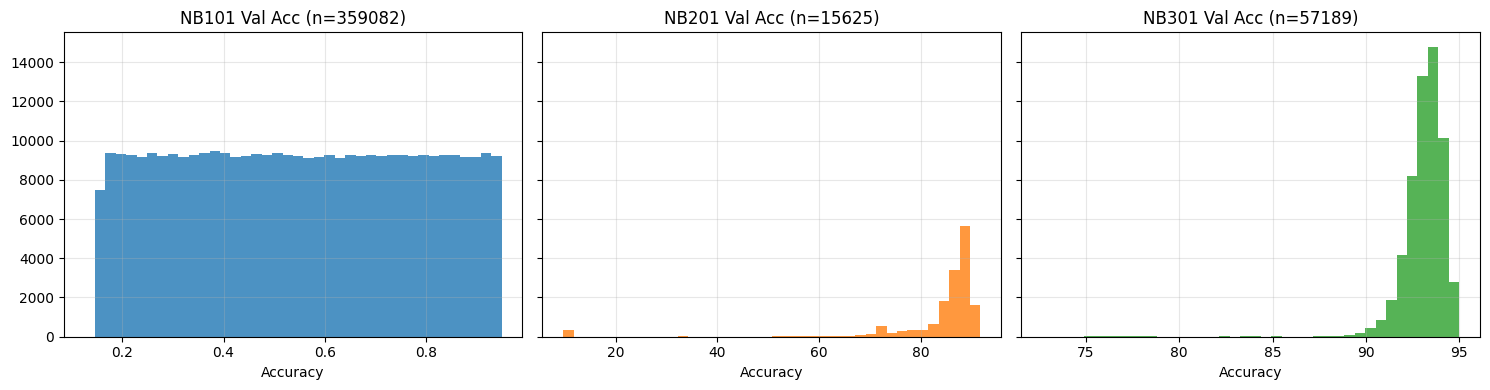

In [8]:
# Plot distributions (full CIFAR-10 validation accuracies)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].hist(nb101_full_vals, bins=40, color='tab:blue', alpha=0.8)
axes[0].set_title(f'NB101 Val Acc (n={len(nb101_full_vals)})')
axes[0].set_xlabel('Accuracy')

axes[1].hist(nb201_full_vals, bins=40, color='tab:orange', alpha=0.8)
axes[1].set_title(f'NB201 Val Acc (n={len(nb201_full_vals)})')
axes[1].set_xlabel('Accuracy')

axes[2].hist(nb301_full_vals, bins=40, color='tab:green', alpha=0.8)
axes[2].set_title(f'NB301 Val Acc (n={len(nb301_full_vals)})')
axes[2].set_xlabel('Accuracy')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Missing (`None`) metrics


In [9]:


random.seed(42)

configs = [
    ('cifar10', 'val', [199, 200]),
    ('cifar10', 'test', [199, 200]),
    ('cifar100', 'val', [199, 200]),
    ('cifar100', 'test', [199, 200]),
    ('ImageNet16-120', 'val', [199, 200]),
    ('ImageNet16-120', 'test', [199, 200]),
]

N = 500
samples = nb201.random_sample(n=N, seed=42)

stats = []
for dataset, split, budgets in configs:
    for b in budgets:
        none_count = 0
        ok_count = 0
        examples_none = []
        for s in samples:
            r = nb201.query(s, dataset=dataset, split=split, budget=b)
            if r['metric'] is None:
                none_count += 1
                if len(examples_none) < 3:
                    examples_none.append(r['info'].get('arch_str', s))
            else:
                ok_count += 1
        stats.append({
            'dataset': dataset,
            'split': split,
            'budget': b,
            'ok': ok_count,
            'none': none_count,
            'none_rate': none_count / float(N),
            'examples': examples_none,
        })

# Display a compact table
for row in stats:
    print(f"{row['dataset']:>14} | {row['split']:>4} | epoch {row['budget']:>3} | ok={row['ok']:>3} none={row['none']:>3} none_rate={row['none_rate']:.2f}")


       cifar10 |  val | epoch 199 | ok=299 none=201 none_rate=0.40
       cifar10 |  val | epoch 200 | ok=299 none=201 none_rate=0.40
       cifar10 | test | epoch 199 | ok=299 none=201 none_rate=0.40
       cifar10 | test | epoch 200 | ok=299 none=201 none_rate=0.40
      cifar100 |  val | epoch 199 | ok=  0 none=500 none_rate=1.00
      cifar100 |  val | epoch 200 | ok=  0 none=500 none_rate=1.00
      cifar100 | test | epoch 199 | ok=299 none=201 none_rate=0.40
      cifar100 | test | epoch 200 | ok=299 none=201 none_rate=0.40
ImageNet16-120 |  val | epoch 199 | ok=  0 none=500 none_rate=1.00
ImageNet16-120 |  val | epoch 200 | ok=  0 none=500 none_rate=1.00
ImageNet16-120 | test | epoch 199 | ok=299 none=201 none_rate=0.40
ImageNet16-120 | test | epoch 200 | ok=299 none=201 none_rate=0.40
